# Stats - frequency

$$f =
    \begin{cases}
    0 & \text{if } (X - P_{10_{hist}}) \geq 0 \\
    1 & \text{if } (X - P_{10_{hist}}) < 0
    \end{cases}
$$

- calculate annual means (or seasonal means for each year)
- calculate the historical 10th percentile from the annual means
- calculate frequency
- calculate average of annual normalised data
- calculate ensemble means

In [21]:
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.climag as cplt
from climag import climag_plot
import pandas as pd
import seaborn as sns

In [56]:
importlib.reload(cplt)

<module 'climag.climag' from '/mnt/Backup/Documents/Git/ClimAg/ClimAg/climag/climag.py'>

## EURO-CORDEX

In [3]:
ds_ec = cplt.load_all_data("EURO-CORDEX")

/mnt/Backup/Documents/Git/ClimAg/ClimAg/.venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


In [11]:
ds_ec["CNRM-CM5_historical"]

<xarray.Dataset> Size: 161MB
Dimensions:       (model: 1, exp: 1, time: 10958, rlat: 33, rlon: 37, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 10kB dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon           (rlat, rlon) float64 10kB dask.array<chunksize=(33, 37), meta=np.ndarray>
  * rlat          (rlat) float64 264B 3.685 3.795 3.905 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 296B -17.27 -17.16 -17.05 ... -13.41 -13.3
  * time          (time) datetime64[ns] 88kB 1976-01-01T12:00:00 ... 2005-12-...
    height        float64 8B 2.0
    rotated_pole  |S1 1B b''
    time_bnds     (time, bnds) datetime64[ns] 175kB dask.array<chunksize=(366, 2), meta=np.ndarray>
  * exp           (exp) <U10 40B 'historical'
  * model         (model) <U8 32B 'CNRM-CM5'
    spatial_ref   int64 8B 0
Dimensions without coordinates: bnds
Data variables:
    bm            (model, exp, time, rlat, rlon) float32 54MB dask.array<chunksize=(1, 1, 366, 33, 37), meta=np.ndarray>
    gro           (model, exp, time, rlat, rlon) float32 54MB dask.array<chunksize=(1, 1, 366, 33, 37), meta=np.ndarray>
    bm_c          (model, exp, time, rlat, rlon) float32 54MB dask.array<chunksize=(1, 1, 366, 33, 37), meta=np.ndarray>
Attributes:
    creation_date:  2023-03-10 16:21:55.203354+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_CNRM-CM5_historical

In [8]:
ds_ec_norm = cplt.calc_event_frequency(ds_ec)

In [9]:
ds_ec_norm

<xarray.Dataset> Size: 21MB
Dimensions:       (rlat: 33, rlon: 37, model: 4, year: 60, exp: 3)
Coordinates:
  * rlat          (rlat) float64 264B 3.685 3.795 3.905 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 296B -17.27 -17.16 -17.05 ... -13.41 -13.3
  * model         (model) <U10 160B 'CNRM-CM5' 'EC-EARTH' ... 'MPI-ESM-LR'
  * year          (year) int64 480B 1976 1977 1978 1979 ... 2067 2068 2069 2070
  * exp           (exp) <U10 120B 'historical' 'rcp45' 'rcp85'
    lat           (rlat, rlon) float64 10kB dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon           (rlat, rlon) float64 10kB dask.array<chunksize=(33, 37), meta=np.ndarray>
    height        float64 8B 2.0
    rotated_pole  |S1 1B b''
    spatial_ref   int64 8B 0
    quantile      float64 8B 0.1
Data variables:
    bm            (year, model, exp, rlat, rlon) float64 7MB dask.array<chunksize=(1, 1, 1, 33, 37), meta=np.ndarray>
    gro           (year, model, exp, rlat, rlon) float64 7MB dask.array<chunksize=(1, 1, 1, 33, 37), meta=np.ndarray>
    bm_c          (year, model, exp, rlat, rlon) float64 7MB dask.array<chunksize=(1, 1, 1, 33, 37), meta=np.ndarray>

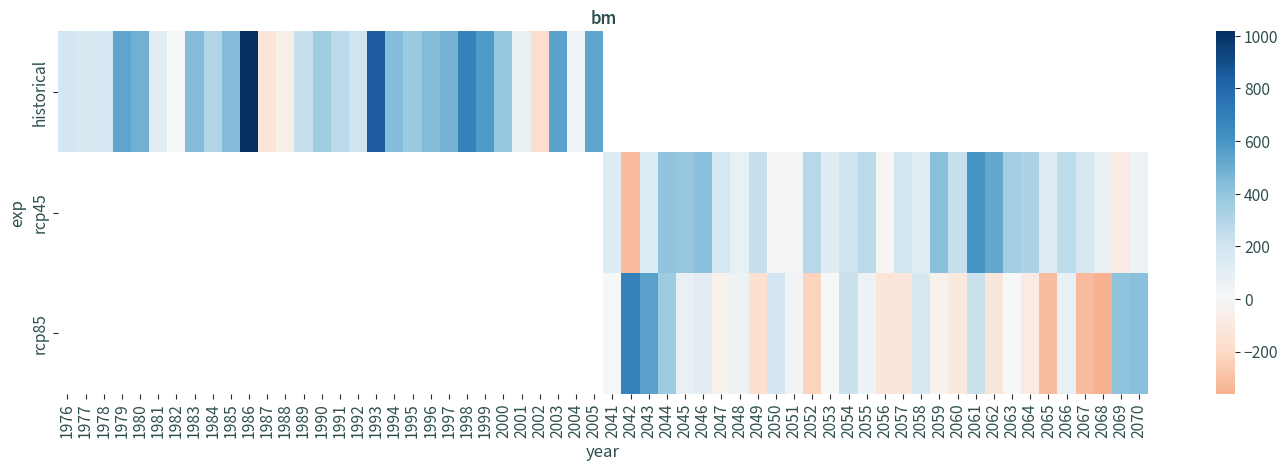

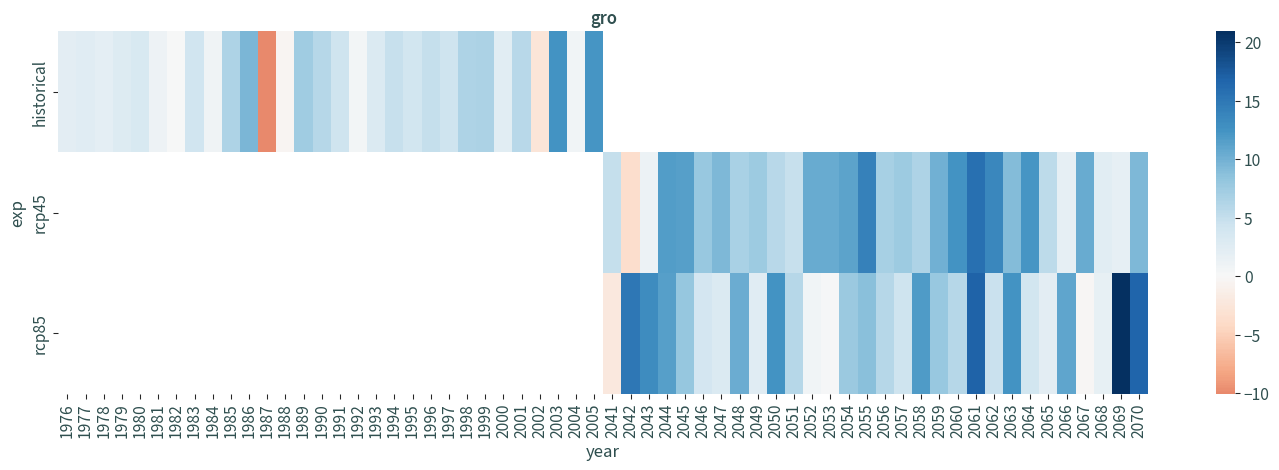

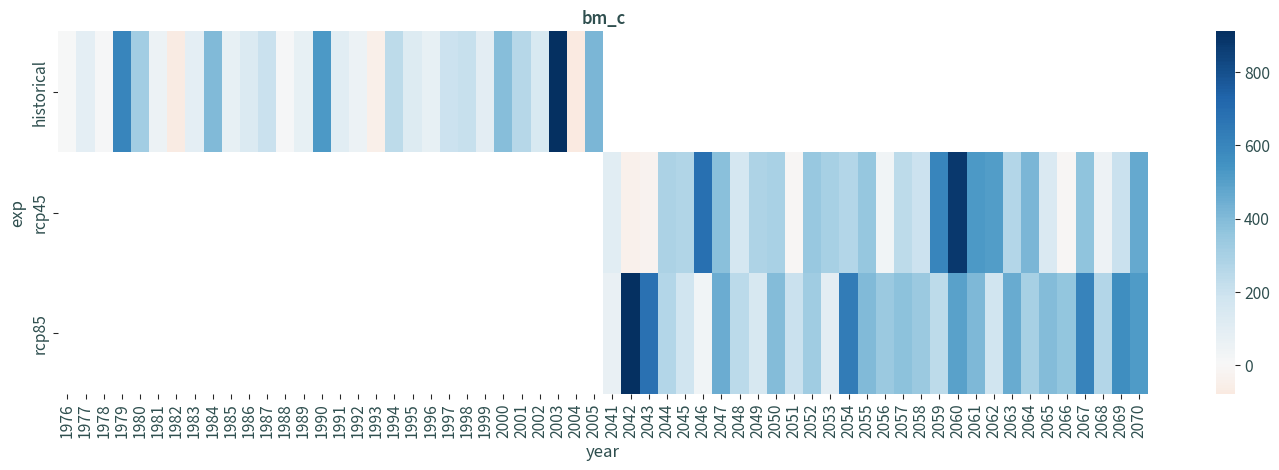

In [49]:
for v in list(ds_ec_norm.data_vars):
    ds_ec_norm_df = ds_ec_norm.isel(model=0, rlat=15, rlon=15)[v].to_dataframe()[[v]].dropna().reset_index().pivot(index="exp", columns="year", values=v)
    plt.figure(figsize=(15, 5))
    sns.heatmap(ds_ec_norm_df, center=0, cmap="RdBu", xticklabels=True)
    plt.title(v)
    plt.tight_layout()
    plt.show()

In [51]:
# set variables < 0 to 1
ds_ec_norm_reduced = xr.where(ds_ec_norm < 0, 1, 0)

In [54]:
ds_ec_norm_reduced = ds_ec_norm_reduced.sum(dim="year", skipna=True).mean(dim="model", skipna=True)

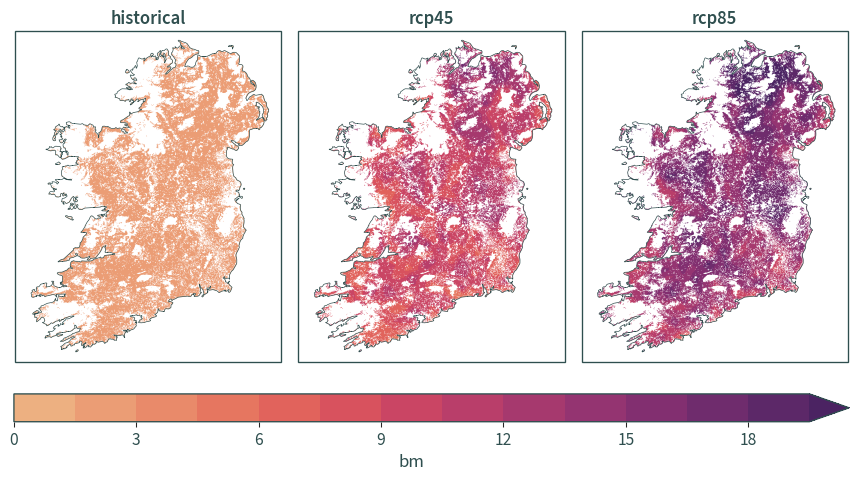

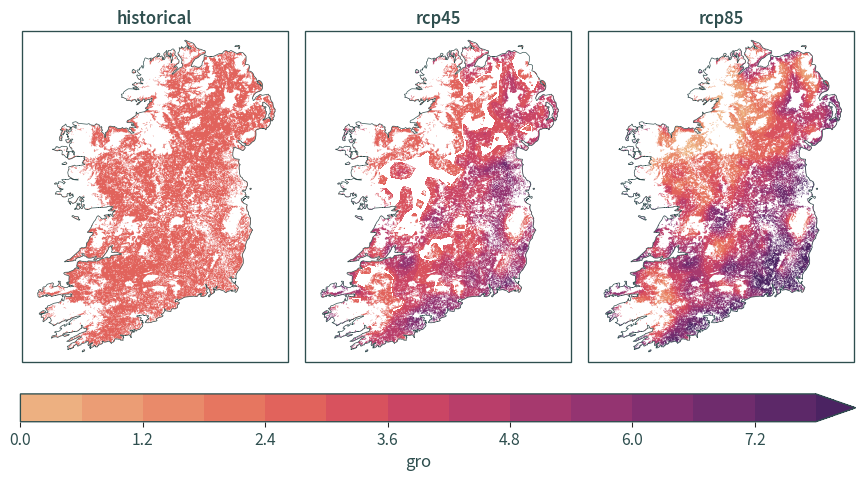

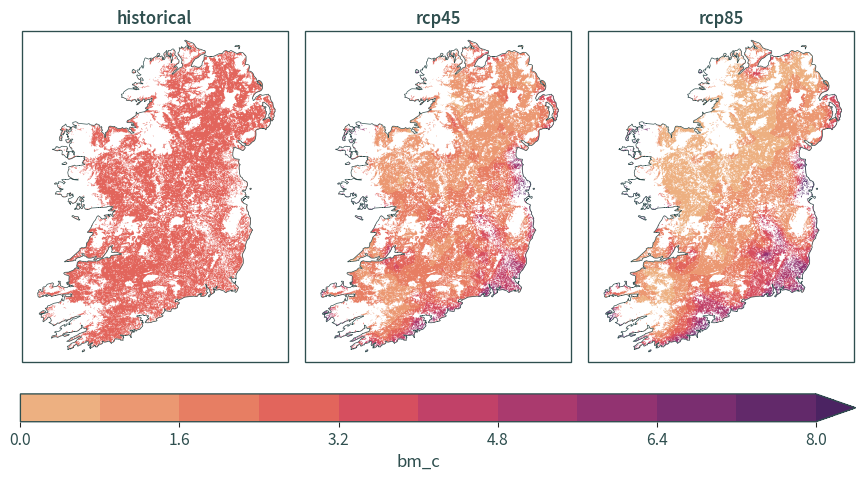

In [57]:
cplt.plot_stats(ds_ec_norm_reduced, cplt.projection_eurocordex, cmap="flare")

## HiResIreland

In [27]:
ds_hr = cplt.load_all_data("HiResIreland")

In [33]:
ds_hr_norm = cplt.calc_normalised_relative(ds_hr)

In [ ]:
# set variables < 0 to 1
ds_hr_norm_reduced = xr.where(ds_hr_norm < 0, 1, 0)

In [35]:
ds_hr_norm_reduced = ds_hr_norm_reduced.sum(dim="year", skipna=True).mean(dim="model", skipna=True)

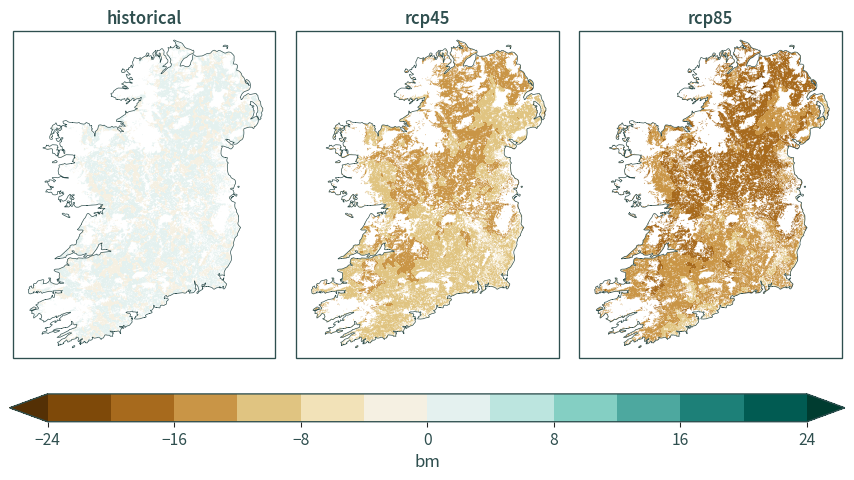

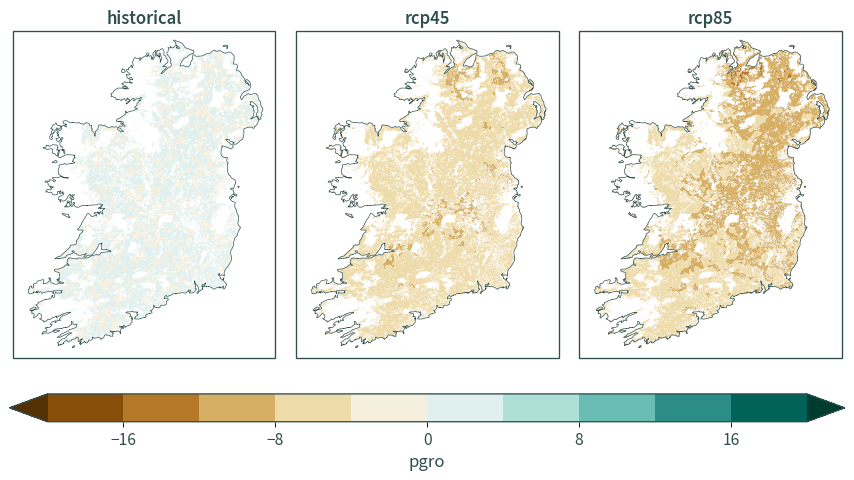

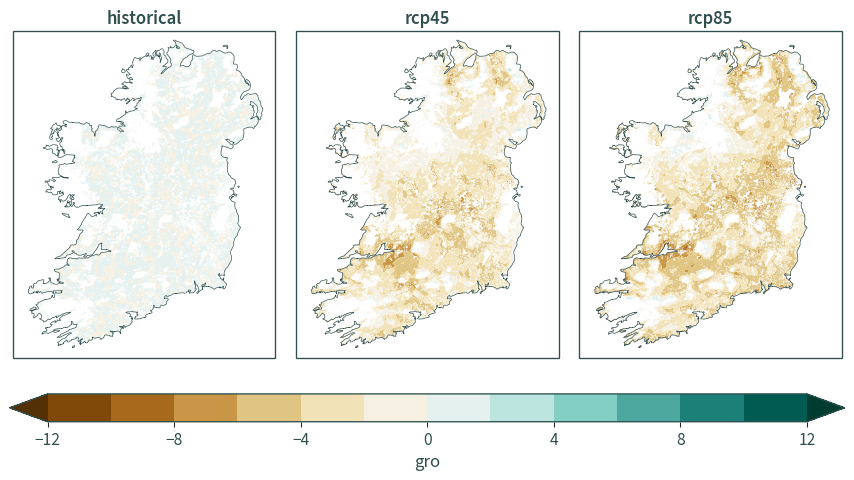

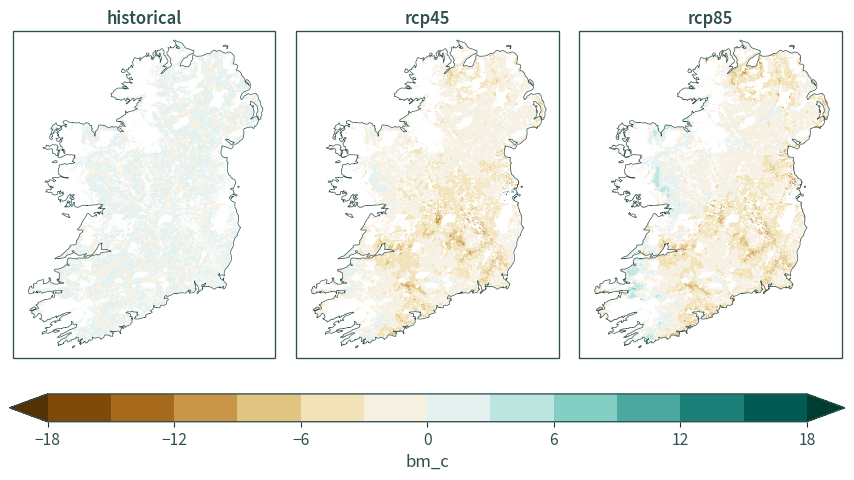

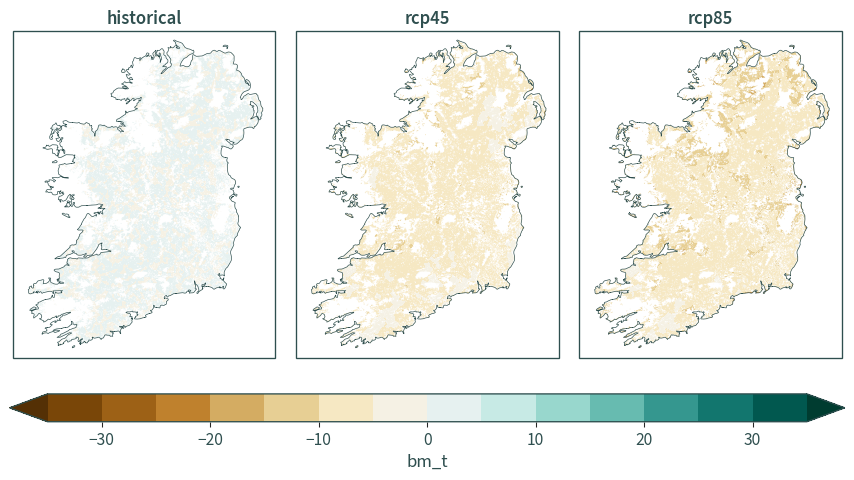

In [39]:
cplt.plot_stats(ds_hr_norm_reduced, cplt.projection_hiresireland)